In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os

from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [12]:
def getConfig(opt, pt='low', mass='higgs'):
    from types import SimpleNamespace
    if pt=='low':
        ptmin, ptmax = 400, 600
    elif pt=='high':
        ptmin, ptmax = 600, 1000
    elif pt=='higher':
        ptmin, ptmax = 1000, 1500
    elif pt=='full':
        ptmin, ptmax = 200, 100000
    
    if mass=='higgs':
        massmin, massmax = 60, 150
    elif mass=='full':
        massmin, massmax = 50, 250
    elif isinstance(mass, tuple):
        massmin, massmax = mass

    routine, sname, bname = opt.split(':')
    cfg = SimpleNamespace(
        year = 2017,
        ptmin = ptmin, ptmax = ptmax,
        filedir = None,
        filelist = {
            'sig': None,
            'bkg': None,
        },
        base_cut = f'(fj_pt>{ptmin}) & (fj_pt<{ptmax}) & (abs(fj_eta)<2.4)',
        mass_cut = f'(fj_sdmass>{massmin}) & (fj_sdmass<{massmax})',
        subtitle = (r'$%d < p_{T,j} < %d$ GeV,  $|\eta_{j}|<2.4$' % (ptmin, ptmax)) if ptmax!=100000 else r'$p_{T,j} > %d$ GeV,  $|\eta_{j}|<2.4$' % (ptmin),
        subtitle2 = r'$%d < m_{SD} < %d$ GeV' % (massmin, massmax),
        label_list = ['label_Top_bWcs', 'label_Top_bWqq', 'label_Top_bWc', 'label_Top_bWs', 'label_Top_bWq', 'label_Top_bWev', 'label_Top_bWmv', 'label_Top_bWtauev', 'label_Top_bWtaumv', 'label_Top_bWtauhv', 'label_Top_Wcs', 'label_Top_Wqq', 'label_Top_Wev', 'label_Top_Wmv', 'label_Top_Wtauev', 'label_Top_Wtaumv', 'label_Top_Wtauhv', 'label_H_bb', 'label_H_cc', 'label_H_ss', 'label_H_qq', 'label_H_bc', 'label_H_bs', 'label_H_cs', 'label_H_gg', 'label_H_ee', 'label_H_mm', 'label_H_tauhtaue', 'label_H_tauhtaum', 'label_H_tauhtauh', 'label_H_WW_cscs', 'label_H_WW_csqq', 'label_H_WW_qqqq', 'label_H_WW_csc', 'label_H_WW_css', 'label_H_WW_csq', 'label_H_WW_qqc', 'label_H_WW_qqs', 'label_H_WW_qqq', 'label_H_WW_csev', 'label_H_WW_qqev', 'label_H_WW_csmv', 'label_H_WW_qqmv', 'label_H_WW_cstauev', 'label_H_WW_qqtauev', 'label_H_WW_cstaumv', 'label_H_WW_qqtaumv', 'label_H_WW_cstauhv', 'label_H_WW_qqtauhv', 'label_H_WxWx_cscs', 'label_H_WxWx_csqq', 'label_H_WxWx_qqqq', 'label_H_WxWx_csc', 'label_H_WxWx_css', 'label_H_WxWx_csq', 'label_H_WxWx_qqc', 'label_H_WxWx_qqs', 'label_H_WxWx_qqq', 'label_H_WxWx_csev', 'label_H_WxWx_qqev', 'label_H_WxWx_csmv', 'label_H_WxWx_qqmv', 'label_H_WxWx_cstauev', 'label_H_WxWx_qqtauev', 'label_H_WxWx_cstaumv', 'label_H_WxWx_qqtaumv', 'label_H_WxWx_cstauhv', 'label_H_WxWx_qqtauhv', 'label_H_WxWxStar_cscs', 'label_H_WxWxStar_csqq', 'label_H_WxWxStar_qqqq', 'label_H_WxWxStar_csc', 'label_H_WxWxStar_css', 'label_H_WxWxStar_csq', 'label_H_WxWxStar_qqc', 'label_H_WxWxStar_qqs', 'label_H_WxWxStar_qqq', 'label_H_WxWxStar_csev', 'label_H_WxWxStar_qqev', 'label_H_WxWxStar_csmv', 'label_H_WxWxStar_qqmv', 'label_H_WxWxStar_cstauev', 'label_H_WxWxStar_qqtauev', 'label_H_WxWxStar_cstaumv', 'label_H_WxWxStar_qqtaumv', 'label_H_WxWxStar_cstauhv', 'label_H_WxWxStar_qqtauhv', 'label_H_ZZ_bbbb', 'label_H_ZZ_bbcc', 'label_H_ZZ_bbss', 'label_H_ZZ_bbqq', 'label_H_ZZ_cccc', 'label_H_ZZ_ccss', 'label_H_ZZ_ccqq', 'label_H_ZZ_ssss', 'label_H_ZZ_ssqq', 'label_H_ZZ_qqqq', 'label_H_ZZ_bbb', 'label_H_ZZ_bbc', 'label_H_ZZ_bbs', 'label_H_ZZ_bbq', 'label_H_ZZ_ccb', 'label_H_ZZ_ccc', 'label_H_ZZ_ccs', 'label_H_ZZ_ccq', 'label_H_ZZ_ssb', 'label_H_ZZ_ssc', 'label_H_ZZ_sss', 'label_H_ZZ_ssq', 'label_H_ZZ_qqb', 'label_H_ZZ_qqc', 'label_H_ZZ_qqs', 'label_H_ZZ_qqq', 'label_H_ZZ_bbee', 'label_H_ZZ_bbmm', 'label_H_ZZ_bbe', 'label_H_ZZ_bbm', 'label_H_ZZ_bee', 'label_H_ZZ_bmm', 'label_H_ZZ_bbtauhtaue', 'label_H_ZZ_bbtauhtaum', 'label_H_ZZ_bbtauhtauh', 'label_H_ZZ_btauhtaue', 'label_H_ZZ_btauhtaum', 'label_H_ZZ_btauhtauh', 'label_H_ZZ_ccee', 'label_H_ZZ_ccmm', 'label_H_ZZ_cce', 'label_H_ZZ_ccm', 'label_H_ZZ_cee', 'label_H_ZZ_cmm', 'label_H_ZZ_cctauhtaue', 'label_H_ZZ_cctauhtaum', 'label_H_ZZ_cctauhtauh', 'label_H_ZZ_ctauhtaue', 'label_H_ZZ_ctauhtaum', 'label_H_ZZ_ctauhtauh', 'label_H_ZZ_ssee', 'label_H_ZZ_ssmm', 'label_H_ZZ_sse', 'label_H_ZZ_ssm', 'label_H_ZZ_see', 'label_H_ZZ_smm', 'label_H_ZZ_sstauhtaue', 'label_H_ZZ_sstauhtaum', 'label_H_ZZ_sstauhtauh', 'label_H_ZZ_stauhtaue', 'label_H_ZZ_stauhtaum', 'label_H_ZZ_stauhtauh', 'label_H_ZZ_qqee', 'label_H_ZZ_qqmm', 'label_H_ZZ_qqe', 'label_H_ZZ_qqm', 'label_H_ZZ_qee', 'label_H_ZZ_qmm', 'label_H_ZZ_qqtauhtaue', 'label_H_ZZ_qqtauhtaum', 'label_H_ZZ_qqtauhtauh', 'label_H_ZZ_qtauhtaue', 'label_H_ZZ_qtauhtaum', 'label_H_ZZ_qtauhtauh', 'label_H_ZxZx_bbbb', 'label_H_ZxZx_bbcc', 'label_H_ZxZx_bbss', 'label_H_ZxZx_bbqq', 'label_H_ZxZx_cccc', 'label_H_ZxZx_ccss', 'label_H_ZxZx_ccqq', 'label_H_ZxZx_ssss', 'label_H_ZxZx_ssqq', 'label_H_ZxZx_qqqq', 'label_H_ZxZx_bbb', 'label_H_ZxZx_bbc', 'label_H_ZxZx_bbs', 'label_H_ZxZx_bbq', 'label_H_ZxZx_ccb', 'label_H_ZxZx_ccc', 'label_H_ZxZx_ccs', 'label_H_ZxZx_ccq', 'label_H_ZxZx_ssb', 'label_H_ZxZx_ssc', 'label_H_ZxZx_sss', 'label_H_ZxZx_ssq', 'label_H_ZxZx_qqb', 'label_H_ZxZx_qqc', 'label_H_ZxZx_qqs', 'label_H_ZxZx_qqq', 'label_H_ZxZx_bbee', 'label_H_ZxZx_bbmm', 'label_H_ZxZx_bbe', 'label_H_ZxZx_bbm', 'label_H_ZxZx_bee', 'label_H_ZxZx_bmm', 'label_H_ZxZx_bbtauhtaue', 'label_H_ZxZx_bbtauhtaum', 'label_H_ZxZx_bbtauhtauh', 'label_H_ZxZx_btauhtaue', 'label_H_ZxZx_btauhtaum', 'label_H_ZxZx_btauhtauh', 'label_H_ZxZx_ccee', 'label_H_ZxZx_ccmm', 'label_H_ZxZx_cce', 'label_H_ZxZx_ccm', 'label_H_ZxZx_cee', 'label_H_ZxZx_cmm', 'label_H_ZxZx_cctauhtaue', 'label_H_ZxZx_cctauhtaum', 'label_H_ZxZx_cctauhtauh', 'label_H_ZxZx_ctauhtaue', 'label_H_ZxZx_ctauhtaum', 'label_H_ZxZx_ctauhtauh', 'label_H_ZxZx_ssee', 'label_H_ZxZx_ssmm', 'label_H_ZxZx_sse', 'label_H_ZxZx_ssm', 'label_H_ZxZx_see', 'label_H_ZxZx_smm', 'label_H_ZxZx_sstauhtaue', 'label_H_ZxZx_sstauhtaum', 'label_H_ZxZx_sstauhtauh', 'label_H_ZxZx_stauhtaue', 'label_H_ZxZx_stauhtaum', 'label_H_ZxZx_stauhtauh', 'label_H_ZxZx_qqee', 'label_H_ZxZx_qqmm', 'label_H_ZxZx_qqe', 'label_H_ZxZx_qqm', 'label_H_ZxZx_qee', 'label_H_ZxZx_qmm', 'label_H_ZxZx_qqtauhtaue', 'label_H_ZxZx_qqtauhtaum', 'label_H_ZxZx_qqtauhtauh', 'label_H_ZxZx_qtauhtaue', 'label_H_ZxZx_qtauhtaum', 'label_H_ZxZx_qtauhtauh', 'label_H_ZxZxStar_bbbb', 'label_H_ZxZxStar_bbcc', 'label_H_ZxZxStar_bbss', 'label_H_ZxZxStar_bbqq', 'label_H_ZxZxStar_cccc', 'label_H_ZxZxStar_ccss', 'label_H_ZxZxStar_ccqq', 'label_H_ZxZxStar_ssss', 'label_H_ZxZxStar_ssqq', 'label_H_ZxZxStar_qqqq', 'label_H_ZxZxStar_bbb', 'label_H_ZxZxStar_bbc', 'label_H_ZxZxStar_bbs', 'label_H_ZxZxStar_bbq', 'label_H_ZxZxStar_ccb', 'label_H_ZxZxStar_ccc', 'label_H_ZxZxStar_ccs', 'label_H_ZxZxStar_ccq', 'label_H_ZxZxStar_ssb', 'label_H_ZxZxStar_ssc', 'label_H_ZxZxStar_sss', 'label_H_ZxZxStar_ssq', 'label_H_ZxZxStar_qqb', 'label_H_ZxZxStar_qqc', 'label_H_ZxZxStar_qqs', 'label_H_ZxZxStar_qqq', 'label_H_ZxZxStar_bbee', 'label_H_ZxZxStar_bbmm', 'label_H_ZxZxStar_bbe', 'label_H_ZxZxStar_bbm', 'label_H_ZxZxStar_bee', 'label_H_ZxZxStar_bmm', 'label_H_ZxZxStar_bbtauhtaue', 'label_H_ZxZxStar_bbtauhtaum', 'label_H_ZxZxStar_bbtauhtauh', 'label_H_ZxZxStar_btauhtaue', 'label_H_ZxZxStar_btauhtaum', 'label_H_ZxZxStar_btauhtauh', 'label_H_ZxZxStar_ccee', 'label_H_ZxZxStar_ccmm', 'label_H_ZxZxStar_cce', 'label_H_ZxZxStar_ccm', 'label_H_ZxZxStar_cee', 'label_H_ZxZxStar_cmm', 'label_H_ZxZxStar_cctauhtaue', 'label_H_ZxZxStar_cctauhtaum', 'label_H_ZxZxStar_cctauhtauh', 'label_H_ZxZxStar_ctauhtaue', 'label_H_ZxZxStar_ctauhtaum', 'label_H_ZxZxStar_ctauhtauh', 'label_H_ZxZxStar_ssee', 'label_H_ZxZxStar_ssmm', 'label_H_ZxZxStar_sse', 'label_H_ZxZxStar_ssm', 'label_H_ZxZxStar_see', 'label_H_ZxZxStar_smm', 'label_H_ZxZxStar_sstauhtaue', 'label_H_ZxZxStar_sstauhtaum', 'label_H_ZxZxStar_sstauhtauh', 'label_H_ZxZxStar_stauhtaue', 'label_H_ZxZxStar_stauhtaum', 'label_H_ZxZxStar_stauhtauh', 'label_H_ZxZxStar_qqee', 'label_H_ZxZxStar_qqmm', 'label_H_ZxZxStar_qqe', 'label_H_ZxZxStar_qqm', 'label_H_ZxZxStar_qee', 'label_H_ZxZxStar_qmm', 'label_H_ZxZxStar_qqtauhtaue', 'label_H_ZxZxStar_qqtauhtaum', 'label_H_ZxZxStar_qqtauhtauh', 'label_H_ZxZxStar_qtauhtaue', 'label_H_ZxZxStar_qtauhtaum', 'label_H_ZxZxStar_qtauhtauh', 'label_QCD_bb', 'label_QCD_cc', 'label_QCD_b', 'label_QCD_c', 'label_QCD_others']
    )
    cfg.label_idx = {lab: i for i, lab in enumerate(cfg.label_list)}
    # v8
    if routine == 'pn_inclv8_originput':
        cfg.label = f'ParticleNet 314-class'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_pn_originput.bs768'
    elif routine == 'part_inclv8_2reg_old':
        cfg.label = f'ParT-lite 314-class (old)'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_2reg_manual.useamp.lite.dp-bs2048-lr0p6e-3.try4'
    elif routine == 'part_inclv8_2reg':
        cfg.label = f'ParT-lite 314-class'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_2reg_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    elif routine == 'part_inclv8_addlosttrk':
        cfg.label = f'ParT-lite 314-class (+lost track)'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addlosttrk_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    # elif routine == 'part_inclv8_addltphp':
    #     cfg.label = f'ParT-lite 314-class (+lost track +pixel hit)'
    #     cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    # elif routine == 'part_inclv8_addltphp_wmeasonly':
    #     cfg.label = f'ParT-lite 314-class (+lost track +pixel hit)'
    #     cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    elif routine == 'part_inclv8_addltphp_wmeasonly.lite':
        cfg.label = f'ParT-lite'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    elif routine == 'part_inclv8_addltphp_wmeasonly.normpair':
        cfg.label = f'ParT-lite 314-class (+lost track +pixel hit meas-only), normpair'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.normpair.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    elif routine == 'part_inclv8_addltphp_wmeaspixeltibonly':
        cfg.label = f'ParT-lite 314-class (+lost track +pixel hit meas+PX+TIB)'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeaspixeltibonly_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3'
    elif routine == 'part_inclv8_addltphp_wmeasonly.standardsize':
        cfg.label = f'ParT-normal'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.standardsize.gm5.ddp-bs512-lr4e-3'
    elif routine == 'part_inclv8_addltphp_wmeasonly.large':
        # cfg.label = f'ParT-Large 314-class (+lost track +pixel hit meas-only)'
        cfg.label = f'ParT-Large'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.large.gm5.ddp-bs256-lr2e-3'
    elif routine == 'origPNetMD':
        cfg.label = 'ParticleNet-MD (official)'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_pn_originput.bs768'
    elif routine == 'origParTMD':
        cfg.label = 'ParticleTransformer-MD (Nov 11)'
        cfg.filedir = '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_pn_originput.bs768'

    else:
        raise RuntimeError('wrong opt')

    # determine which file to use
    name_choices = ['HIGLO', 'HIGHI', 'HWWLO', 'HWWHI', 'HIGGS2P', 'HWW', 'QCD', 'TTBARINCL', 'TTBAR']
    cfg.filelist['sig'] = [os.path.join(cfg.filedir, f'pred_{n.lower()}.root') for n in name_choices if sname.startswith(n)][0]
    cfg.filelist['bkg'] = [os.path.join(cfg.filedir, f'pred_{n.lower()}.root') for n in name_choices if bname.startswith(n)][0]
    sname = sname.replace('HIGLO','HIG').replace('HIGHI','HIG').replace('HWWLO','HWW').replace('HWWHI','HWW')
    bname = bname.replace('HIGLO','HIG').replace('HIGHI','HIG').replace('HWWLO','HWW').replace('HWWHI','HWW')

    # deal with variables
    variable_dict = {
        'QCD': ['label_QCD_bb', 'label_QCD_cc', 'label_QCD_b', 'label_QCD_c', 'label_QCD_others'],
        **{f'HIG{n}': [f'label_H_{n}'] for n in ['bb', 'cc', 'qq', 'ss', 'bc', 'cs', 'bs', 'gg', 'ee', 'mm', 'tauhtaue', 'tauhtaum', 'tauhtauh']},
        **{f'HIGGS2P{n}': [f'label_H_{n}'] for n in ['bb', 'cc', 'qq', 'ss', 'bc', 'cs', 'bs', 'gg', 'ee', 'mm', 'tauhtaue', 'tauhtaum', 'tauhtauh']},
        **{f'HWW{n}': [f'label_H_WW_{n}'] for n in ['cscs', 'csqq', 'qqqq', 'csc', 'css', 'csq', 'qqc', 'qqs', 'qqq', 'csev', 'qqev', 'csmv', 'qqmv', 'cstauev', 'qqtauev', 'cstaumv', 'qqtaumv', 'cstauhv', 'qqtauhv']},
        **{f'TTBAR{n}': [f'label_Top_{n}'] for n in ['bWcs', 'bWqq', 'bWc', 'bWs', 'bWq', 'bWev', 'bWmv', 'bWtauev', 'bWtaumv', 'bWtauhv', 'Wcs', 'Wqq', 'Wev', 'Wmv', 'Wtauev', 'Wtaumv', 'Wtauhv']},
        'HWWQQQQ': [f'label_H_WW_{n}' for n in ['cscs', 'csqq', 'qqqq']],
        'HWWWxWxQQQQ': [f'label_H_WxWx_{n}' for n in ['cscs', 'csqq', 'qqqq']],
        'HWWQQQ': [f'label_H_WW_{n}' for n in ['csc', 'css', 'csq', 'qqc', 'qqs', 'qqq']],
        'HWWQQev': [f'label_H_WW_{n}' for n in ['csev', 'qqev']],
        'HWWQQmv': [f'label_H_WW_{n}' for n in ['csmv', 'qqmv']],
        'HWWQQtauev': [f'label_H_WW_{n}' for n in ['cstauev', 'qqtauev']],
        'HWWQQtaumv': [f'label_H_WW_{n}' for n in ['cstaumv', 'qqtaumv']],
        'HWWQQtauhv': [f'label_H_WW_{n}' for n in ['cstauhv', 'qqtauhv']],
        'HWWel': [f'label_H_WW_{n}' for n in ['csev', 'cstauev', 'qqev', 'qqtauev']],
        'HWWmu': [f'label_H_WW_{n}' for n in ['csmv', 'cstaumv', 'qqmv', 'qqtaumv']],
        'TTBARbWall': [f'label_Top_{n}' for n in ['bWcs', 'bWqq', 'bWc', 'bWs', 'bWq', 'bWev', 'bWmv', 'bWtauev', 'bWtaumv', 'bWtauhv']],
        'TTBARall': [f'label_Top_{n}' for n in ['bWcs', 'bWqq', 'bWc', 'bWs', 'bWq', 'bWev', 'bWmv', 'bWtauev', 'bWtaumv', 'bWtauhv', 'Wcs', 'Wqq', 'Wev', 'Wmv', 'Wtauev', 'Wtaumv', 'Wtauhv']],
    }
    label_dict = {
        'QCD': 'QCD',
        'HWWWxWxQQQQ': r'H$\rightarrow$WW 4q', 
        'HWWQQQQ': r'H$\rightarrow$WW 4q', 'HWWQQQ': r'H$\rightarrow$WW 3q', 'HWWQQev': r'H$\rightarrow$WW $e\nu qq$', 'HWWQQmv': r'H$\rightarrow$WW $\mu\nu qq$', 'HWWQQtauev': r'H$\rightarrow$WW $\tau_e\nu qq$', 'HWWQQtaumv': r'H$\rightarrow$WW $\tau_\mu\nu qq$', 'HWWQQtauhv': r'H$\rightarrow$WW $\tau_h\nu qq$',
        'HIGbb': r'H$\rightarrow$bb', 'HIGcc': r'H$\rightarrow$cc', 'HIGss': r'H$\rightarrow$ss', 'HIGqq': r'H$\rightarrow$qq', 'HIGbc': r'$H^\pm \rightarrow$bc', 'HIGcs': r'$H^\pm \rightarrow$cs', 'HIGbs': r'$H\rightarrow$bs', 'HIGgg': r'$H\rightarrow$gg', 'HIGee': r'$H\rightarrow$ee', 'HIGmm': r'$H\rightarrow \mu\mu$', 'HIGtauhvtauev': r'H$\rightarrow\tau_h\tau_e$', 'HIGtauhvtaumv': r'H$\rightarrow\tau_h\tau_\mu$', 'HIGtauhvtauhv': r'H$\rightarrow\tau_h\tau_h$', 
        'HIGtauhtaue': r'H$\rightarrow\tau_h\tau_e$', 'HIGtauhtaum': r'H$\rightarrow\tau_h\tau_\mu$', 'HIGtauhtauh': r'H$\rightarrow\tau_h\tau_h$', 
        'HIGGS2Pbb': r'H$\rightarrow$bb', 'HIGGS2Pcc': r'H$\rightarrow$cc', 'HIGGS2Pss': r'H$\rightarrow$ss', 'HIGGS2Pqq': r'H$\rightarrow$qq', 'HIGGS2Pbc': r'$H^\pm \rightarrow$bc', 'HIGGS2Pcs': r'$H^\pm \rightarrow$cs', 'HIGGS2Pbs': r'$H\rightarrow$bs', 'HIGGS2Pgg': r'$H\rightarrow$gg', 'HIGGS2Pee': r'$H\rightarrow$ee', 'HIGGS2Pmm': r'$H\rightarrow \mu\mu$', 'HIGGS2Ptauhvtauev': r'H$\rightarrow\tau_h\tau_e$', 'HIGGS2Ptauhvtaumv': r'H$\rightarrow\tau_h\tau_\mu$', 'HIGGS2Ptauhvtauhv': r'H$\rightarrow\tau_h\tau_h$', 
        'HIGGS2Ptauhtaue': r'H$\rightarrow\tau_h\tau_e$', 'HIGGS2Ptauhtaum': r'H$\rightarrow\tau_h\tau_\mu$', 'HIGGS2Ptauhtauh': r'H$\rightarrow\tau_h\tau_h$', 
        'TTBARbWqq': r't$\overline{t}$ bW(2q)', 'TTBARbWq': r't$\overline{t}$ bW(1q)', 'TTBARbWev': r't$\overline{t}$ bW(e\nu)', 'TTBARbWmv': r't$\overline{t}$ bW(\mu\nu)', 'TTBARbWtauev': r't$\overline{t}$ bW(\tau_e\nu)', 'TTBARbWtaumv': r't$\overline{t}$ bW(\tau_\mu\nu)', 'TTBARbWtauhv': r't$\overline{t}$ bW(\tau_h\nu)',
        'TTBARbWall': r't$\rightarrow$bW all', 'TTBARall': r'Top (bW, W) all', 'TTBARhad': r't$\rightarrow$bW had.', 'TTBARel': r't$\rightarrow bW \rightarrow be\nu$', 'TTBARmu': r't$\rightarrow bW \rightarrow b\mu\nu$', 'TTBARta': r't$\rightarrow bW \rightarrow b\tau\nu$',
        'TTBARINCLall': r't$\rightarrow$bW all (incl.)', 'TTBARINCLhad': r't$\rightarrow$bW had. (incl.)', 'TTBARINCLel': r't$\rightarrow bW \rightarrow be\nu$ (incl.)', 'TTBARINCLmu': r't$\rightarrow bW \rightarrow b\mu\nu$ (incl.)', 
        'XBCbc': r'$H\prime\rightarrow$bc', 
    }
    cfg.y_sig_flag = ' | '.join([f'(fj_label == {cfg.label_idx[lab]})' for lab in variable_dict[sname.replace('WxWx','')]])
    cfg.y_bkg_flag = ' | '.join([f'(fj_label == {cfg.label_idx[lab]})' for lab in variable_dict[bname]])
    
    y_score_sig = ' + '.join([f'score_{lab}' for lab in variable_dict[sname]])
    y_score_bkg = ' + '.join([f'score_{lab}' for lab in variable_dict[bname]])
    cfg.y_score = f'({y_score_sig}) / (({y_score_sig}) + ({y_score_bkg}))'

    cfg.title = f'{label_dict[sname]} vs {label_dict[bname]}'

    # special treatment
    import re
    cfg.y_sig_flag = cfg.y_sig_flag + ' '
    cfg.y_bkg_flag = cfg.y_bkg_flag + ' '
    cfg.y_score = cfg.y_score + ' '

    # speical treatment on variables
    if routine in ['origPNetMD', 'origPNetMDEOY']:
        exist_variable_dict = {
            'QCD': ' + '.join([f'pfMassDecorrelatedParticleNetJetTags_probQCD{n}' for n in ['b', 'bb', 'c', 'cc', 'others']]),
            **{f'HIGGS2P{n}': f'pfMassDecorrelatedParticleNetJetTags_probX{n}' for n in ['bb', 'cc', 'qq']},
            **{f'HIG{n}': f'pfMassDecorrelatedParticleNetJetTags_probX{n}' for n in ['bb', 'cc', 'qq']},
        }
        cfg.y_score = f'({exist_variable_dict[sname]}) / (({exist_variable_dict[sname]}) + ({exist_variable_dict[bname]}))'
    if routine == 'origParTMD':
        exist_variable_dict = {
            'QCD': ' + '.join([f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probQCD{n}' for n in ['b', 'bb', 'c', 'cc', 'others']]),
            **{f'HIGGS2P{n}': f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}' for n in ['bb', 'cc', 'ss', 'qq', 'tauhtaue', 'tauhtaum', 'tauhtauh']},
            **{f'HIG{n}': f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}' for n in ['bb', 'cc', 'ss', 'qq', 'tauhtaue', 'tauhtaum', 'tauhtauh']},
            'HWWQQQQ': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}2c'.format(n='WqqWqq'),
            'HWWQQQ':  'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}2c'.format(n='WqqWq'),
            'HWWQQev': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c'.format(n='WqqWev'),
            'HWWQQmv': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c'.format(n='WqqWmv'),
            'HWWQQtauev': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c'.format(n='WqqWtauev'),
            'HWWQQtaumv': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c'.format(n='WqqWtaumv'),
            'HWWQQtauhv': 'pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}0c + pfMassDecorrelatedInclParticleTransformerV1JetTags_probH{n}1c'.format(n='WqqWtauhv'),
            'TTBARbWall': ' + '.join([f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probTop{n}' for n in ['bWqq0c', 'bWqq1c', 'bWq0c', 'bWq1c', 'bWev', 'bWmv', 'bWtauev', 'bWtaumv', 'bWtauhv']]),
            'TTBARall': ' + '.join([f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probTop{n}' for n in ['bWqq0c', 'bWqq1c', 'bWq0c', 'bWq1c', 'bWev', 'bWmv', 'bWtauev', 'bWtaumv', 'bWtauhv']]),
            'TTBARbWqq': ' + '.join([f'pfMassDecorrelatedInclParticleTransformerV1JetTags_probTop{n}' for n in ['bWqq0c', 'bWqq1c']]),
        }
        cfg.y_score = f'({exist_variable_dict[sname]}) / (({exist_variable_dict[sname]}) + ({exist_variable_dict[bname]}))'

    return cfg

In [3]:
def plot_roc_curve(sname, bname, samples, pt='low', mass='higgs', ymin=1e-4, xtext=0.5, store_plot=False, subdir='', genm=100):
    colorlist = ['blue', 'red', 'green', 'darkorange', 'darkviolet', 'cyan']
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f, ax = plt.subplots()
    hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')
    from scipy.interpolate import interp1d

    # create dataframe
    for sam in samples:
        opt = f'{sam}:{sname}:{bname}'
        config = getConfig(opt, pt=pt, mass=mass)

        print(opt)
        print(config.filelist, config.y_sig_flag, config.y_bkg_flag, config.y_score)

        dfs = uproot.lazy(config.filelist['sig']+':Events')
        dfb = uproot.lazy(config.filelist['bkg']+':Events')
        # apply final cut to the dataset
        dfs = dfs[ak.numexpr.evaluate(f"({config.y_sig_flag}) & ({config.base_cut}) & ({config.mass_cut})", dfs)]
        dfb = dfb[ak.numexpr.evaluate(f"({config.y_bkg_flag}) & ({config.base_cut}) & ({config.mass_cut})", dfb)]

        y_score_s = ak.numexpr.evaluate(config.y_score, dfs)
        y_score_b = ak.numexpr.evaluate(config.y_score, dfb)
        y_score = ak.concatenate([y_score_s, y_score_b])

        if genm is not None:
            genm_cut_str = f'abs((fj_gen_mass / {genm}) - 1) < 1e-3'
            y_score_s = y_score_s[ak.numexpr.evaluate(genm_cut_str, dfs)]
            if bname.startswith('HIG') or bname.startswith('HWW'):
                y_score_b = y_score_b[ak.numexpr.evaluate(genm_cut_str, dfb)]
            y_score = ak.concatenate([y_score_s, y_score_b])
        
        y_true = ak.concatenate([ak.ones_like(y_score_s, dtype=bool), ak.zeros_like(y_score_b, dtype=bool)])
        print(ak.sum(y_true), ak.sum(~y_true))

        fpr, tpr, _thres = m.roc_curve(y_true, y_score)
        ax.plot(tpr, fpr, label=config.label)
        # draw 1% line
        func = interp1d(fpr, tpr)
        ax.plot([0, 1], [0.01, 0.01], ':', color='grey')
        ax.plot([func(0.01), func(0.01)], [0, 0.01], ':', color='grey')


    ax.legend(loc='upper left', labelspacing=0.8) #prop={'size': 22}, 
    ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(ymin, 1)
    ax.set_xlabel('Signal efficiency', ha='right', x=1.0); ax.set_ylabel('Background efficiency', ha='right', y=1.0); 
    # x_text, y_text = 0.0, 0.6
    x_text, y_text = xtext, 0.05
    ax.text(x_text+0.03, y_text+0.13, config.title + (r' ($m_H$: %d)' % genm if genm is not None else ''), fontsize=22, fontweight='bold', transform=ax.transAxes)
    ax.text(x_text+0.03, y_text+0.06, config.subtitle, fontsize=18, transform=ax.transAxes)
    ax.text(x_text+0.03, y_text+0.00, config.subtitle2, fontsize=18, transform=ax.transAxes)
    if store_plot:
        os.makedirs(f'../plots/plots_230508_inclv8/{subdir}', exist_ok=True)
        plt.savefig(f'../plots/plots_230508_inclv8/{subdir}/roc_{sname}_{bname}_{"-".join(samples)}_{pt}_{mass}_{genm}.pdf', bbox_inches='tight')
        plt.savefig(f'../plots/plots_230508_inclv8/{subdir}/roc_{sname}_{bname}_{"-".join(samples)}_{pt}_{mass}_{genm}.png', bbox_inches='tight')


part_inclv8_2reg:HIGGS2Pcc:QCD
{'sig': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_2reg_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_higgs2p.root', 'bkg': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_2reg_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_qcd.root'} (fj_label == 18)  (fj_label == 309) | (fj_label == 310) | (fj_label == 311) | (fj_label == 312) | (fj_label == 313)  (score_label_H_cc) / ((score_label_H_cc) + (score_label_QCD_bb + score_label_QCD_cc + score_label_QCD_b + score_label_QCD_c + score_label_QCD_others)) 
57103 222697
part_inclv8_addlosttrk:HIGGS2Pcc:QCD
{'sig': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addlosttrk_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_higgs2p.root', 'bkg': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addlosttrk_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_qcd.root'} (fj_label == 18)  (f

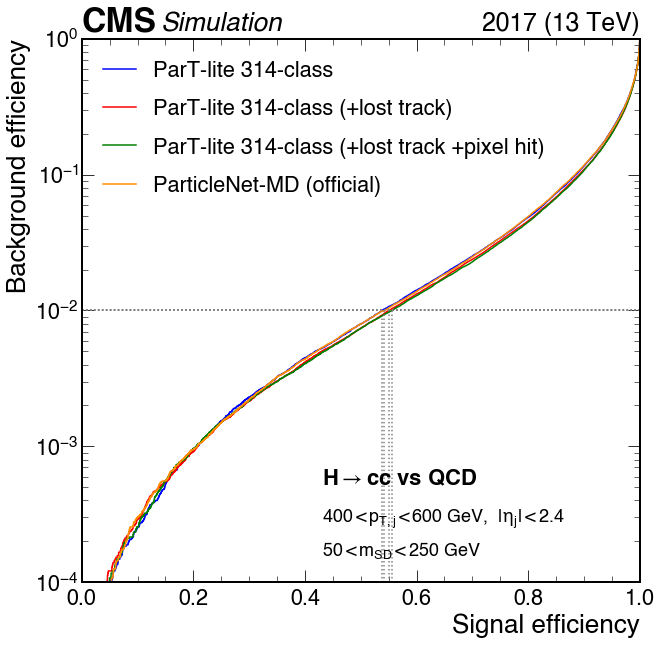

In [11]:
# for pt in ['low']:
    # plot_roc_curve(f'HIGGS2Pbb', 'QCD', samples=['part_inclv8_2reg', 'part_inclv8_addlosttrk', 'part_inclv8_addltphp_wmeasonly', 'origPNetMD'], pt=pt, mass='full', store_plot=True, subdir='v8_ofc', xtext=0.4, genm=None)
    # plot_roc_curve(f'HIGGS2Pcc', 'QCD', samples=['part_inclv8_2reg', 'part_inclv8_addlosttrk', 'part_inclv8_addltphp_wmeasonly', 'origPNetMD'], pt=pt, mass='full', store_plot=True, subdir='v8_ofc', xtext=0.4, genm=None)
    # plot_roc_curve(f'HIGGS2Pbb', 'HIGGS2Pcc', samples=['part_inclv8_2reg', 'part_inclv8_addlosttrk', 'part_inclv8_addltphp_wmeasonly', 'origPNetMD'], pt=pt, mass='full', store_plot=True, subdir='v8_ofc', xtext=0.4, genm=None)

part_inclv8_addltphp_wmeasonly.lite:HIGGS2Pcc:HIGGS2Pbb
{'sig': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_higgs2p.root', 'bkg': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.lite.gm5.ddp-bs768-lr6p75e-3/pred_higgs2p.root'} (fj_label == 18)  (fj_label == 17)  (score_label_H_cc) / ((score_label_H_cc) + (score_label_H_bb)) 
86622 84855
part_inclv8_addltphp_wmeasonly.standardsize:HIGGS2Pcc:HIGGS2Pbb
{'sig': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.standardsize.gm5.ddp-bs512-lr4e-3/pred_higgs2p.root', 'bkg': '/home/olympus/licq/hww/incl-train/weaver-core/weaver/predict/ak8_MD_inclv8_part_addltphp_wmeasonly_manual.useamp.standardsize.gm5.ddp-bs512-lr4e-3/pred_higgs2p.root'} (fj_label == 18)  (fj_label == 17)  (score_label_H_cc) / ((score_label_H_cc)

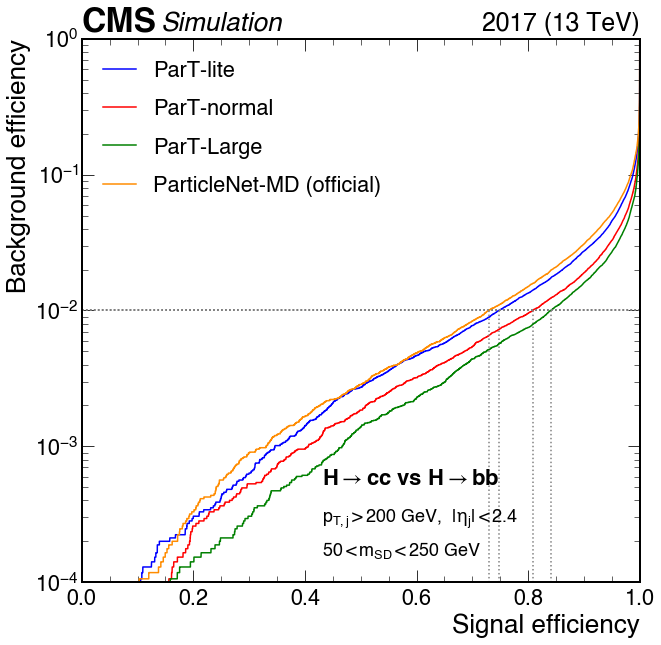

In [15]:
# plot_roc_curve(f'HIGGS2Pbb', 'QCD', samples=['part_inclv8_addltphp_wmeasonly.lite', 'part_inclv8_addltphp_wmeasonly.standardsize', 'part_inclv8_addltphp_wmeasonly.large', 'origPNetMD'], pt='full', mass='full', store_plot=True, subdir='v8_ofcscale', xtext=0.4, genm=None)
# plot_roc_curve(f'HIGGS2Pcc', 'QCD', samples=['part_inclv8_addltphp_wmeasonly.lite', 'part_inclv8_addltphp_wmeasonly.standardsize', 'part_inclv8_addltphp_wmeasonly.large', 'origPNetMD'], pt='full', mass='full', store_plot=True, subdir='v8_ofcscale', xtext=0.4, genm=None)
plot_roc_curve(f'HIGGS2Pcc', 'HIGGS2Pbb', samples=['part_inclv8_addltphp_wmeasonly.lite', 'part_inclv8_addltphp_wmeasonly.standardsize', 'part_inclv8_addltphp_wmeasonly.large', 'origPNetMD'], pt='full', mass='full', store_plot=True, subdir='v8_ofcscale', xtext=0.4, genm=None)
# plot_roc_curve(f'HWWQQQQ', 'QCD', samples=['part_inclv8_addltphp_wmeasonly.lite', 'part_inclv8_addltphp_wmeasonly.standardsize', 'part_inclv8_addltphp_wmeasonly.large'], pt='full', mass='full', store_plot=True, subdir='v8_ofcscale', xtext=0.4, genm=None)
# plot_roc_curve(f'HWWQQQQ', 'TTBARall', samples=['part_inclv8_addltphp_wmeasonly.lite', 'part_inclv8_addltphp_wmeasonly.standardsize', 'part_inclv8_addltphp_wmeasonly.large'], pt='full', mass='full', store_plot=True, subdir='v8_ofcscale', xtext=0.4, genm=None)